In [1]:
import napari_clusters_plotter as ncp
import pyclesperanto_prototype as cle
import matplotlib.pyplot as plt
import pandas as pd
from skimage.io import imread
import napari

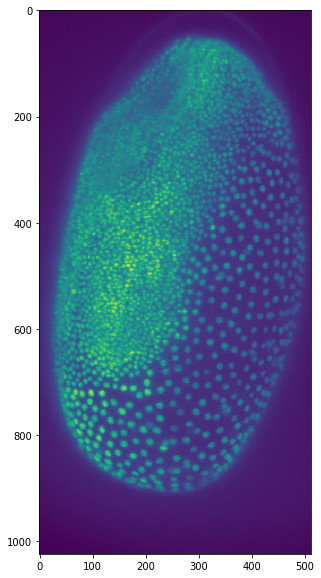

In [2]:
%matplotlib inline
tribolium = imread('lund_i000217_oi_001007.tif')
plt.figure(figsize=(10,10))
cle.imshow(tribolium)

In [3]:
tribolium.shape

(71, 1024, 512)

In [4]:
def resample_isotropic_nodownsample(image_3d,voxelsize_zyx):
    import numpy as np
    import pyclesperanto_prototype as cle
    # we need to select a powerful GPU for this
    cle.select_device("GTX")
    if voxelsize_zyx[2] == voxelsize_zyx[1]:
        voxelsize_zyx = np.array(voxelsize_zyx)
        norm_voxelsize = voxelsize_zyx/voxelsize_zyx[2]
        input_image = cle.push_zyx(image_3d)
        resampled_image = cle.resample(input_image, factor_x=norm_voxelsize[2], 
                                       factor_y=norm_voxelsize[1], factor_z=norm_voxelsize[0])
        image_array = cle.pull_zyx(resampled_image)
        return image_array

voxel_size_yzx = [3.0, 0.6934, 0.6934]
resampled_tribolium = resample_isotropic_nodownsample(cle.push(tribolium), voxel_size_yzx)
resampled_tribolium.shape

(307, 1024, 512)

In [5]:
# This workflow does a good job of approximating cellular regions around the nuclei
def workflow(image, number_of_dilations = 15, number_of_erosions = 9):
    import numpy as np
    import pyclesperanto_prototype as cle    

    gpu_input = cle.push(image)

    # Spot detection
    # After some noise removal/smoothing, we perform a local maximum detection

    # gaussian blur -> needs adjusting, maybe even other filters for preprocessing
    gpu_tophat = cle.top_hat_sphere(gpu_input,radius_x=7, radius_y=7, radius_z=7)
    gpu_blurred = cle.gaussian_blur(gpu_tophat, sigma_x=1, sigma_y=1, sigma_z=2) 
    gpu_input = None
    # detect maxima: instead of a pointslist we get and image with white pixels at the maxima locations
    gpu_detected_maxima = cle.detect_maxima_box(gpu_blurred)
    gpu_tophat = None
    # Spot curation
    # Now, we remove spots with values below a certain intensity and label the remaining spots

    # threshold
    gpu_thresholded = cle.threshold_otsu(gpu_blurred)
    gpu_blurred = None

    # mask
    gpu_masked_spots = cle.mask(gpu_detected_maxima, gpu_thresholded)
    gpu_detected_maxima = None
    gpu_thresholded = None
    # label spots
    gpu_labelled_spots = cle.connected_components_labeling_box(gpu_masked_spots)
    gpu_masked_spots = None
    
    number_of_spots = cle.maximum_of_all_pixels(gpu_labelled_spots)
    print("Number of detected spots: " + str(number_of_spots))
    # retrieve the image to take a look at the maxima in napari
    # label map closing

    flip = cle.create_like(gpu_labelled_spots)
    flop = cle.create_like(gpu_labelled_spots)
    flag = cle.create([1,1,1])
    cle.copy(gpu_labelled_spots, flip)

    for i in range (0, number_of_dilations) :
        cle.onlyzero_overwrite_maximum_box(flip, flag, flop)
        cle.onlyzero_overwrite_maximum_diamond(flop, flag, flip)
    
    gpu_labelled_spots = None
    
    flap = cle.greater_constant(flip, constant= 1)

    for i in range(0, number_of_erosions):
        cle.erode_box(flap, flop)
        cle.erode_sphere(flop, flap)

    gpu_labels = cle.mask(flip, flap)
    flip = None
    flop = None
    flap = None
    flag = None
    
    alllabels = cle.close_index_gaps_in_label_map(gpu_labels)
    output = cle.pull(alllabels)
    print('Label Numbering Starts at {val}'.format(val = np.min(output[np.nonzero(output)])))
    print('Workflow Completed')
    return output

labels = workflow(resampled_tribolium)

Number of detected spots: 3034.0
Label Numbering Starts at 1
Workflow Completed


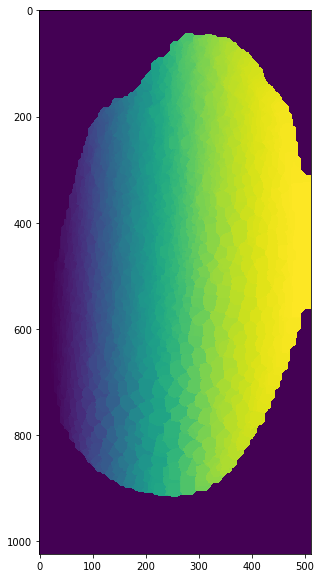

In [6]:
plt.figure(figsize=(10,10))
cle.imshow(labels)

In [8]:
from napari_clusters_plotter._measure import get_regprops_from_regprops_source

region_properties = pd.DataFrame(get_regprops_from_regprops_source(intensity_image = resampled_tribolium, 
                                                                   label_image = labels, 
                                                                   region_props_source = 'neighborhood', 
                                                                   n_closest_points_list= [2,3,4]))
region_properties

Measurements Completed.


,label,min_intensity,max_intensity,sum_intensity,area,mean_intensity,centroid_x,centroid_y,centroid_z,mean_distance_to_centroid,standard_deviation_intensity,max_distance_to_centroid,mean_max_distance_to_centroid_ratio,avg distance of 2 closest points,avg distance of 3 closest points,avg distance of 4 closest points,touching neighbor count
0,1,297.0,688.0,1507217.0,3523.0,427.822021,28.074368,569.345154,30.254896,7.493289,90.644218,15.568646,2.077678,13.023781,13.095436,14.170271,8.0
1,2,342.0,397.0,14309.0,38.0,376.552643,44.394737,599.973694,18.289474,2.124861,11.092192,3.745637,1.762768,11.366500,12.725294,13.705290,5.0
2,3,312.0,423.0,30563.0,85.0,359.564728,43.694118,644.447083,23.400000,3.002683,24.153650,7.706779,2.566631,13.180609,13.663043,14.908041,3.0
3,4,308.0,606.0,1516254.0,3489.0,434.581268,34.265404,588.595276,20.821438,8.598204,54.375763,17.635021,2.051012,13.975037,14.464319,14.781386,12.0
4,5,316.0,509.0,473305.0,1275.0,371.219604,45.784313,597.621155,6.842353,6.662396,27.826416,14.822598,2.224815,14.422382,15.496941,16.682144,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3027,3028,168.0,467.0,5974456.0,23924.0,249.726471,497.093994,395.776550,30.814413,13.936218,41.142258,26.234236,1.882450,27.119427,27.751448,28.208418,4.0
3028,3029,185.0,469.0,4954575.0,18783.0,263.779724,497.477814,419.822693,20.653942,13.068819,40.862297,24.980949,1.911492,22.505583,23.706207,24.992966,5.0
3029,3030,189.0,400.0,5611269.0,22309.0,251.524902,497.198181,493.721649,11.088933,13.726714,29.086742,26.711351,1.945939,28.245502,28.979330,30.942081,4.0
3030,3031,200.0,501.0,4736093.0,17204.0,275.290222,497.667236,443.427399,11.949140,12.685946,43.526855,27.922712,2.201075,22.011726,23.060926,25.109392,4.0
